### This notebook is for sampling a large image into sub images with Uniformly distributed rotation and X, Y coordinates.
### Crop image at X,Y and rotate for Image data augmentation.
### Every pixel must be sampled atleast once (do this randomly)
### Sample is within image range
### rotations should be distributed uniformly
### Extract annotation and transform each annotated coordinates for each individual window extract annotations
### Plots include 1) heatmap of sampled pixels and angles and 
### TODO: 2) histogram for random sampled 100 pixels

In [2]:
import math
import cv2
import numpy as np
# check Pillow version number
import PIL
print('Pillow Version:', PIL.__version__)
import numpy as np
import os
from pathlib import Path
import re
import json

# load and show an image with Pillow
from PIL import Image, ImageDraw
Image.MAX_IMAGE_PIXELS = None
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import misc
from scipy.ndimage import rotate

Pillow Version: 8.1.0


### create a new directory, if directory does not exist

In [2]:
def create_new_directory(path: Path):
    """Create new directory, if directory does not exist."""
    assert path, "Invalid path."
    if os.path.exists(path):
        print("%s Directory already created " % path)
    else:
        try:
            os.mkdir(path)
        except OSError:
            print ("Creation of the directory %s failed" % path)
        else:
            print ("Successfully created the directory %s " % path)
    return True

#### Generate X, Y samples for given crop_length and number of samples for each of X, Y

In [3]:
def generate_sample_xy(W:int,H:int,crop_len:float,x_slice_count:int,y_slice_count:int ):
    """Generate Unifromly distributed samples for X, Y"""
    assert W and H and crop_len, "generate_sample_xy(W:int,H:int,crop_len:float,x_slice_count:int,y_slice_count:int ): Invalid width or height or crop length."
    assert x_slice_count and y_slice_count, "generate_sample_xy(W:int,H:int,crop_len:float,x_slice_count:int,y_slice_count:int ): Number of samples count for X or Y are empty."
    X_H = int(W - crop_len)
    Y_H = int(H - crop_len)
    X = np.random.uniform(low=crop_len, high=X_H, size=x_slice_count).astype(int)
    Y = np.random.uniform(low=crop_len, high=Y_H, size=y_slice_count).astype(int)

    return X,Y

#### Plot X, Y sample distribution

In [4]:
def plot_sample_distr(S:np.array,var_name:str):
    assert S.shape, "Invalid Numpy array."
    
    s = np.sort(S)
    import matplotlib.pyplot as plt

    count, bins, ignored = plt.hist(s, 10, facecolor='steelblue') 
    mn,mx = min(s),max(s)
    plt.xlabel(var_name+'~U['+str(mn)+','+str(mx)+']')
    plt.ylabel('Count')
    plt.plot(bins, np.full_like(bins,6), linewidth=2, color='r')
    plt.title("Uniform Distribution Histogram (Bin size 20)")
    plt.axis([mn,mx, 0, 10]) # x_start, x_end, y_start, y_end
    plt.grid(True)

    plt.show(block = False)

#### Get transformed length and cosine, sine of given rotation angle

In [5]:
def get_transformed_length(angle:int, target_croplen:int ):
    """
    For a given target crop length, get transformed new crop length and the cosine and sine of given angle in degrees.
    """
    assert target_croplen, "Function get_transformed_length(angle:int, target_croplen:int ): Invalid crop length."
    rad = np.deg2rad(angle)
    c, s = np.cos(rad), np.sin(rad)
    #define width for intermediate cropping process
    croptx = round(abs(target_croplen*c)+abs(target_croplen*s))
    return (c,s,croptx)

#### The first crop method with X,Y for transformed crop length (as against target crop length)

In [6]:
def crop_first_subimage(im:Image, xy:tuple, croptx:int):
    """
    Crop the first subimage with transformed croplength and return numpy array.
    """
    assert xy and croptx, "Function crop_first_subimage(im:Image, xy:tuple, croptx:int): Invalid crop coordinates or crop length."
    x,y = xy
    box = (x-croptx, y-croptx, x+croptx, y+croptx)
    #print(box)
    crop1 = im.crop(box)
    xt,yt = int(crop1.size[0]/2),int(crop1.size[1]/2)
    croparr = np.asarray(crop1)
    return croparr

#### Rotate the Image to a given angle around center of given cropped image 

In [7]:
def rotate_image(image:np.array, angle:int):
    """
    Rotate the OpenCV image around its center at an angle.
    Output image: rotated image with black background (Exapnded to fit in the rotated image)
    """
    
    assert image.shape, "Invalid input crop image."
    
    #get image shape and center
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    # Get numpy rotation matrix
    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    # get halved image length and height
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    #rotated coordinates from corners
    rotated_coords = [
        (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    #size of new image
    #x coodinates
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    #y coordinates
    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    # get all bounds to new image
    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    # to keep image center translated
    trans_mat = np.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # get rotation and translation transformation
    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    #apply transformations (rotation and translation)
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result

#### The largest rotated rectangle in a given rotated image at an angle 

In [8]:
def largest_rotated_rect(w:int, h:int, angle:int):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle  within the rotated rectangle.
    """
    
    assert w and h, "Function largest_rotated_rect(w:int, h:int, angle:int): Invalid width and height."
    
    #convert to quadrant
    
    quadrant = int(math.floor(angle / (math.pi / 2))) & 3  #angle/pi/2
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle 
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )

#### Finally crop the target slice froma round center of image

In [9]:
def crop_around_center(image:np.array, width:int, height:int):
    """
    Crop around center of the image
    """
    assert image.shape, "Invalid image."
    assert width and height, "Function crop_around_center(image:np.array, width:int, height:int): Invalid width or height."
    
    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))

    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]

    x1 = int(image_center[0] - math.floor(width * 0.5))
    x2 = int(image_center[0] + math.floor(width * 0.5))
    y1 = int(image_center[1] - math.floor(height * 0.5))
    y2 = int(image_center[1] + math.floor(height * 0.5))

    return image[y1:y2, x1:x2], [y1,y2, x1,x2]

#### Plot the heatmapt of the pixel counter to count the number of times each pixel was sampled.

In [10]:
def generate_heatmap(pixel_counter:np.array, title:str, filepath:str):
    plt.imshow(pixel_counter, cmap='Blues', interpolation='nearest')
    plt.colorbar(label="Pixel coverage density", orientation="vertical")
    plt.title(title)
    plt.savefig(filepath)
    plt.show()

#### Rotate and crop given cropped slice. This method includes rotating, finding maximum rectangle in rotated image and cropping from around center. 

In [11]:
def crop_rotate_image(crop1_arr:np.array,angle:int, show_plot:bool):
    """
    Rotate the cropped image, crop the target crop area that is Largest rotated area rectangle.
    """
    
    assert crop1_arr.shape,"Function crop_rotate_image(crop1_arr:np.array,angle:int, show_plot:bool): Invalid crop array."
    
    image = cv2.cvtColor(crop1_arr, cv2.COLOR_RGB2BGR) #COLOR_BGR2RGB
    image_height, image_width = image.shape[0:2]

    #for i in np.arange(0, 360, 0.5):
    image_orig = np.copy(image)
    image_orig_rgb = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB) 
    
    image_rotated = rotate_image(image, angle)
    image_rotated_rgb = cv2.cvtColor(image_rotated, cv2.COLOR_BGR2RGB) 
    
    image_rotated_cropped ,l = crop_around_center(
        image_rotated,
        *largest_rotated_rect(
            image_width,
            image_height,
            math.radians(angle)
        )
    )
    y1,y2, x1,x2 = l
    image_rotated_cropped_rgb = cv2.cvtColor(image_rotated_cropped, cv2.COLOR_BGR2RGB) 
    
    if show_plot:
        plt.figure(figsize=(5, 5))
        #plt.imshow( image_orig_rgb)
        plt.figure(figsize=(5, 5))
        plt.title("Cropped image after rotation at angle"+str(angle))
        plt.imshow( image_rotated_rgb)
        plt.figure(figsize=(5, 5))
        plt.title("Rotated image at angle after target crop"+str(angle))
        plt.imshow( image_rotated_cropped_rgb)
    
    return image_rotated_cropped_rgb

In [3]:
def update_pixel_counter(mainimg_grayscale:np.array, finalcrop:np.array,showplot:bool, pixel_counter:np.array ):
    #opencvImage1 = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)
    #gray_img = cv2.cvtColor(opencvImage1,cv2.COLOR_BGR2GRAY)

    # convert final cropped image to grascale
    opencvImage2 = cv2.cvtColor(finalcrop, cv2.COLOR_RGB2BGR)
    template = cv2.cvtColor(opencvImage2,cv2.COLOR_BGR2GRAY)

    # get  width and height of grayscaled final cropped image
    w,h = template.shape[::-1]
    #print(w,h)
    
    #match the template
    result = cv2.matchTemplate(mainimg_grayscale, template, cv2.TM_CCOEFF_NORMED)
    
    #get min, max values along rows and columns
    (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(result)
    
    (startX, startY) = maxLoc
    endX = startX + template.shape[1]
    endY = startY + template.shape[0]
    
    #for "this" matched pixel locations, update the pixel counter
    pixel_counter[startY:endY, startX:endX] += 1
    
    # show the output image
    if showplot:    
        # draw the bounding box on the main image 
        cv2.rectangle(mainimg_grayscale, (startX, startY), (endX, endY), (255, 0, 0), 1)
        plt.figure(figsize=(5, 5))
        plt.imshow(mainimg_grayscale)
        plt.title("Marking the matching crop on main image")
    return pixel_counter

#### Generate subimages for a given rotation angle, target path to save subimages.

In [13]:
def generate_sub_images(im:Image, Theta:list, target_croplen:int,targetpath:Path, show_plot:bool):
    
    assert im, "Invalid image."
    assert target_croplen, "Invalid crop length."
    
    print("***************Start generating sub-images ****************")
    
    assert im.size, "Image is empty or invalid."
    assert len(Theta)>0, "Rotation angle list is empty."
    assert target_croplen, "Target Crop length is invalid."
    
    num_of_samples = len(Theta)
    W_I,H_I = im.size
    tot_pixels = W_I*H_I
    
    imfilename, ext = os.path.splitext(os.path.basename(im.filename))
    #create annotation gallery
    targetsubfolder = targetpath.joinpath("subimages")
    create_new_directory(targetsubfolder)
                
    x_slice_count = math.ceil(W_I / target_croplen)
    y_slice_count = math.ceil(H_I / target_croplen)
    print("Number of X and Y values are : " , x_slice_count,y_slice_count)
    print("Number sub images count will be : " , x_slice_count*y_slice_count*num_of_samples)
    
    pixel_counter= np.empty(shape=( W_I,H_I))
    px_counter = 0
    ids = list(range(x_slice_count*y_slice_count*num_of_samples))
    
    imarr = np.asarray(im)
    opencvImage1 = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)
    mainimg_grayscale = cv2.cvtColor(opencvImage1,cv2.COLOR_BGR2GRAY)
    
    for i,angle in enumerate(Theta):
        #angle = Theta[:1][0]
        subfolder = targetsubfolder.joinpath(str(angle))
        create_new_directory(subfolder)
        c,s,croptx = get_transformed_length(angle,target_croplen)
        print("Rotation angle is : " , angle)
        px_counter += croptx

        X,Y = generate_sample_xy(W_I,H_I,croptx,x_slice_count,y_slice_count )
        
        #plot_sample_distr(X.tolist(),"X")
        #plot_sample_distr(Y.tolist(),"Y")

        for x in X.tolist():
            for y in Y.tolist():
                crop1_arr = crop_first_subimage(im, (x,y), croptx)
                crop1arr = imarr[y:y+croptx, x:x+croptx]
                if show_plot:
                    plt.figure(figsize=(5, 5))
                    plt.imshow(crop1arr)
                    plt.title("Crop slice from : x:" + str(x)+", y:"+str(y)+" from "+imfilename)
                finalcrop = crop_rotate_image(crop1arr, angle, show_plot)
                filename=imfilename+"_"+str(ids[i]).zfill(8)+"_"+str(angle)+"_"+str(x)+"_"+str(y)+".jpg"
                filepath = os.path.join(subfolder, filename)
                cv2.imwrite(str(filepath),cv2.cvtColor(finalcrop, cv2.COLOR_BGR2RGB))
                
                #all pixels should have been covered atleast once for the rotation angle of 0 degrees
                if angle == 0:
                    pixel_counter += 1
                else:
                    pixel_counter = update_pixel_counter(mainimg_grayscale,finalcrop,False, pixel_counter )
                    
        print(np.all(pixel_counter[:, 0] >= 1), pixel_counter.shape)
        heatmapfilename="heatmap_"+imfilename+"_"+str(ids[i]).zfill(8)+"_"+str(angle)+".jpg"
        filepath = os.path.join(targetpath, heatmapfilename)
        generate_heatmap(pixel_counter, "Pixel heatmap for file "+imfilename+" angle: "+str(angle), filepath)

#### Sample the given image to generate sub-images.

#### Start sampling for source folder with set of images. This method is targetted for a specific dataset. The dataset folder (i.e. source folder) contains multiple image folders each containing  main image.
#### This method generate sub images for each of the folder.

#### This is an example path. The source folder contains images with 12.5cm Ground sampling distance.

In [14]:
def sample_image(imfilepath : Path, targetfolder : Path, annotationfilepath : Path, Theta:list,target_croplen:int, show_plot:bool):
    
    assert len(Theta)>0, "Rotation angle list is empty."
    assert target_croplen, "Target Crop length is invalid."
    
    print("***************Start sampling image : "+str(imfilepath)+"****************")
    #path to one image file to test
    #p = os.path.join(r'C:\Users\exx\Documents\lab\AGRC(Utah)\01 HRO 2012 (12.5cm)\12SVK260260')
    #imgpath = os.path.join(p,'12SVK260260.png')
    assert os.path.exists(imfilepath), "Image file path does not exists."
    
    im = Image.open(imfilepath)
    
    assert im, "Invalid Image"
    
    out = os.path.join(targetfolder)
    #print(out,os.path.isdir(out))
    
    if not os.path.isdir(out):
        create_new_directory(out)
    
    #open image
   
    print(im.mode, im.size)
    generate_sub_images(im, Theta, target_croplen,targetfolder, show_plot)

In [15]:
def start_sampling(target_croplen : int, sourcefolderpath : str, targetfoldername : str, num_of_samples, show_plot:bool):
    
    #get new folder's storage entry folder, there on, folders likely similar ?
    filedir = Path(sourcefolderpath)
                           #"0001","0001","01 Final Annotation Galleries"
        
    #create target directory under parent directory of Source folder i.e. sourcefolderpath
    targetroot = Path(targetfoldername)
    create_new_directory(targetroot)

    main_folders = [filedir.joinpath(name) for name in os.listdir(filedir)] 
    results = dict()
    annotations_count = 0
    
    Theta = np.random.uniform(low=0, high=360, size=num_of_samples).astype(int).tolist()
    
    if min(Theta) > 0:
        Theta.append(0)
    Theta.sort()
    print("Rotation angles are sampled. Minimum and maximum rotation angles are: ", min(Theta), max(Theta))
    
    for f in main_folders[:1]:
        print("folder", f)
        this_key = None
        for root, dirs, files in os.walk(f):
            #ignore ipynb_checkpoints folders
            if re.search(".ipynb_checkpoints",os.path.basename(Path(root))) or \
            re.search("Final Annotation Galleries",str(Path(root))):
                continue
            if len(dirs) != 0:
                #check if Annotation galleries exist
                galleries = [ dirs.remove(d) for d in dirs if re.search("Final Annotation Galleries",str(d)) or ".ipynb_checkpoints" in d]
                #check if main image file exists 000X_000X_image.png exists ?
                image_files = [ file for file in files if re.search("[A-Za-z0-9]*.png",file)]
                annotation_file = [ file for file in files if re.search("[A-Za-z0-9]*(_)annotations.json",file)]

            #valid folders and files exists ?
            if len(image_files) > 0 :
                #prepare results dict serializable for Json format.
                results = dict()
                this_key = root
                results["file"] = image_files[0]
                results["locations"] = dict()
                imfilepath = Path(root, image_files[0])
                annotationfilepath = Path(root, annotation_file[0])
                print(root)
                
                #create main folder XXXXX
                targetmainfolder = targetroot.joinpath(os.path.basename(Path(f)))
                create_new_directory(targetmainfolder)
                
                #create actual main image subfolder i.e. 000Y
                targetfolder = targetmainfolder.joinpath(os.path.basename(Path(root)))
                create_new_directory(targetfolder)
                
                sample_image(imfilepath, targetfolder, annotationfilepath, Theta, target_croplen, show_plot)

C:\Users\exx\Documents\lab\AGRC(Utah)\test Directory already created 
Rotation angles are sampled. Minimum and maximum rotation angles are:  0 307
folder C:\Users\exx\Documents\lab\AGRC(Utah)\01 HRO 2012 (12.5cm)\12SVK260260
C:\Users\exx\Documents\lab\AGRC(Utah)\01 HRO 2012 (12.5cm)\12SVK260260
C:\Users\exx\Documents\lab\AGRC(Utah)\test\12SVK260260 Directory already created 
C:\Users\exx\Documents\lab\AGRC(Utah)\test\12SVK260260\12SVK260260 Directory already created 
***************Start sampling image : C:\Users\exx\Documents\lab\AGRC(Utah)\01 HRO 2012 (12.5cm)\12SVK260260\12SVK260260.png****************
RGBA (16000, 16000)
***************Start generating sub-images ****************
C:\Users\exx\Documents\lab\AGRC(Utah)\test\12SVK260260\12SVK260260\subimages Directory already created 
Number of X and Y values are :  21 21
Number sub images count will be :  11466
Successfully created the directory C:\Users\exx\Documents\lab\AGRC(Utah)\test\12SVK260260\12SVK260260\subimages\0 
Rotation 

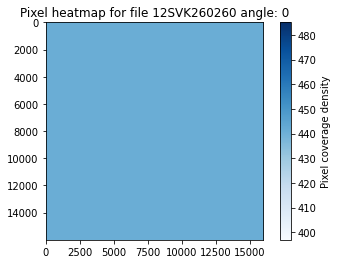

Successfully created the directory C:\Users\exx\Documents\lab\AGRC(Utah)\test\12SVK260260\12SVK260260\subimages\4 
Rotation angle is :  4
True (16000, 16000)


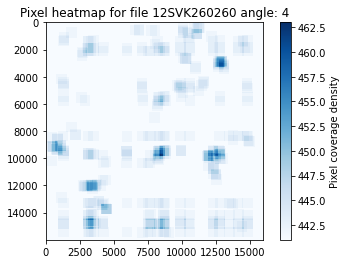

Successfully created the directory C:\Users\exx\Documents\lab\AGRC(Utah)\test\12SVK260260\12SVK260260\subimages\18 
Rotation angle is :  18


In [ ]:
root = os.path.join(r'C:\Users\exx\Documents\lab\AGRC(Utah)')
sourcefolderpath = os.path.join(root,'01 HRO 2012 (12.5cm)')
targetfoldername = os.path.join(root,"test")
start_sampling( 768,sourcefolderpath, targetfoldername,25, False)

786432

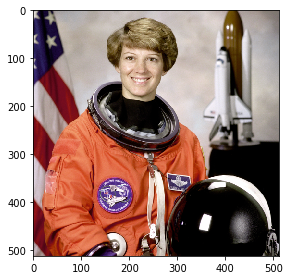

In [15]:
from skimage.io import imread, imshow
from skimage import data

image = data.astronaut()
imshow(image)
image.size

In [16]:
image.shape

(512, 512, 3)

In [17]:

target_croplen = 256
num_of_samples = 25
#create target directory under parent directory of Source folder i.e. sourcefolderpath
targetroot = Path(os.path.join(os.getcwd(), "test"))
create_new_directory(targetroot)

results = dict()
annotations_count = 0

Theta = np.random.uniform(low=0, high=360, size=num_of_samples).astype(int).tolist()

if min(Theta) > 0:
    Theta.append(0)
Theta.sort()
print("Rotation angles are sampled. Minimum and maximum rotation angles are: ", min(Theta), max(Theta))

this_key = None

#prepare results dict serializable for Json format.
results = dict()
results["file"] = ""
results["locations"] = dict()

#create actual main image subfolder i.e. 000Y
#targetfolder = targetmainfolder.joinpath(os.path.basename(Path(root)))
#create_new_directory(targetfolder)

#create annotation gallery
targetsubfolder = os.path.join(targetroot,"subimages")
create_new_directory(targetsubfolder)

#sample_image_exmaple(targetsubfolder, Theta, target_croplen, True)

C:\Users\exx\Documents\lab\code\jlab\Untitled Folder\test Directory already created 
Rotation angles are sampled. Minimum and maximum rotation angles are:  0 359
C:\Users\exx\Documents\lab\code\jlab\Untitled Folder\test\subimages Directory already created 


True

In [18]:
image = data.astronaut()
im = Image.fromarray(image)

W_I,H_I = im.size
tot_pixels = W_I*H_I

x_slice_count = math.ceil(W_I / target_croplen)
y_slice_count = math.ceil(H_I / target_croplen)
print("Number of X and Y values are : " , x_slice_count,y_slice_count)
print("Number sub images count will be : " , x_slice_count*y_slice_count*num_of_samples)

pixel_counter= np.empty(shape=( W_I,H_I))
px_counter = 0
ids = list(range(x_slice_count*y_slice_count*num_of_samples))

imarr = np.asarray(im)
angle = Theta[1]
c,s,croptx = get_transformed_length(angle,target_croplen)
print("Rotation angle is : " , angle)
print("Transformed croplen ",croptx)
px_counter += croptx

X,Y = generate_sample_xy(W_I,H_I,croptx,x_slice_count,y_slice_count )
x,y = 0,0

Number of X and Y values are :  2 2
Number sub images count will be :  100
Rotation angle is :  15
Transformed croplen  314


In [19]:
crop1arr = imarr[y:y+croptx, x:x+croptx]
crop1arr.shape

(314, 314, 3)

Text(0.5, 1.0, 'first crop tx')

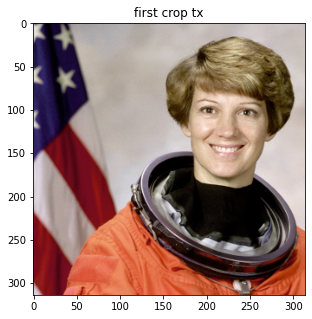

In [20]:
plt.figure(figsize=(5, 5))
plt.imshow(crop1arr)
plt.title("first crop tx")

<Figure size 360x360 with 0 Axes>

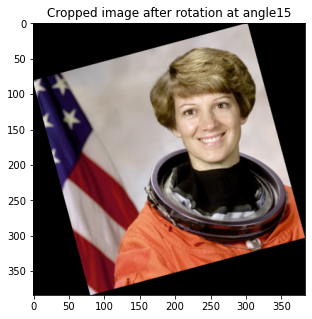

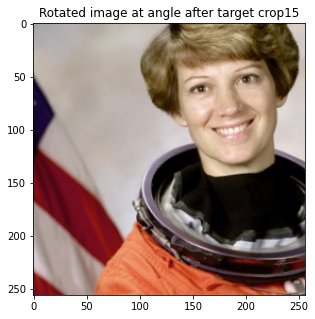

In [21]:
finalcrop = crop_rotate_image(crop1arr, angle, True)

In [22]:
finalcrop.shape, imarr.shape

((256, 256, 3), (512, 512, 3))

256 256


Text(0.5, 1.0, 'actual crop on main image')

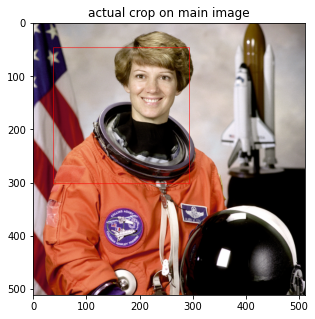

In [23]:
import cv2
import numpy as np

#img = cv2.imread("brows.PNG")              #main image
# gray_img = imarr[:, :, ::-1].copy()
opencvImage1 = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)
gray_img = cv2.cvtColor(opencvImage1,cv2.COLOR_BGR2GRAY)

# template = finalcrop[:, :, ::-1].copy()
opencvImage2 = cv2.cvtColor(finalcrop, cv2.COLOR_RGB2BGR)
template = cv2.cvtColor(opencvImage2,cv2.COLOR_BGR2GRAY)

# print(template.shape, gray_img.shape)
w,h = template.shape[::-1]
print(w,h)

result = cv2.matchTemplate(gray_img, template, cv2.TM_CCOEFF_NORMED)
(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(result)
(startX, startY) = maxLoc
endX = startX + template.shape[1]
endY = startY + template.shape[0]
# draw the bounding box on the image
cv2.rectangle(imarr, (startX, startY), (endX, endY), (255, 0, 0), 1)
# show the output image
plt.figure(figsize=(5, 5))
plt.imshow(imarr)
plt.title("actual crop on main image")


Text(0.5, 1.0, ' crop target')

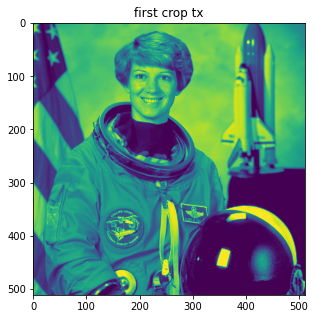

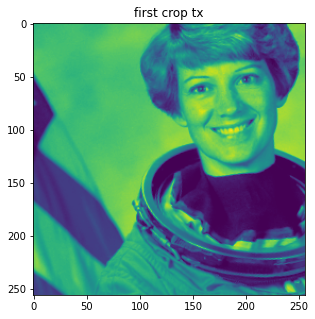

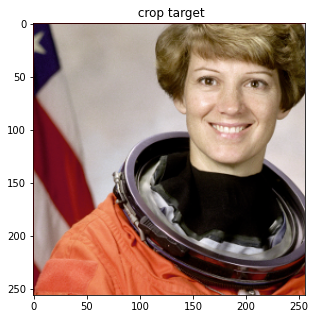

In [24]:
plt.figure(figsize=(5, 5))
plt.imshow(gray_img)
plt.title("first crop tx")

plt.figure(figsize=(5, 5))
plt.imshow(template)
plt.title("first crop tx")

plt.figure(figsize=(5, 5))
plt.imshow(imarr[startY:endY, startX:endX])
plt.title(" crop target")

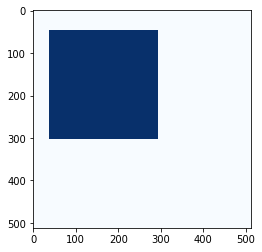

In [25]:
pixel_counter[startY:endY, startX:endX] += 1
generate_heatmap(pixel_counter)

In [26]:

target_croplen = 768
num_of_samples = 25
#create target directory under parent directory of Source folder i.e. sourcefolderpath
targetroot = Path(os.path.join(os.getcwd(), "test"))
create_new_directory(targetroot)

results = dict()
annotations_count = 0

Theta = np.random.uniform(low=0, high=360, size=num_of_samples).astype(int).tolist()

if min(Theta) > 0:
    Theta.append(0)
Theta.sort()
print("Rotation angles are sampled. Minimum and maximum rotation angles are: ", min(Theta), max(Theta))

this_key = None

#prepare results dict serializable for Json format.
results = dict()
results["file"] = ""
results["locations"] = dict()

#create actual main image subfolder i.e. 000Y
#targetfolder = targetmainfolder.joinpath(os.path.basename(Path(root)))
#create_new_directory(targetfolder)

#create annotation gallery
targetsubfolder = os.path.join(targetroot,"subimages")
create_new_directory(targetsubfolder)

#sample_image_exmaple(targetsubfolder, Theta, target_croplen, True)

C:\Users\exx\Documents\lab\code\jlab\Untitled Folder\test Directory already created 
Rotation angles are sampled. Minimum and maximum rotation angles are:  0 357
C:\Users\exx\Documents\lab\code\jlab\Untitled Folder\test\subimages Directory already created 


True

In [27]:
im = Image.open(r'C:\Users\exx\Documents\lab\AGRC(Utah)\01 HRO 2012 (12.5cm)\12SVK260260\12SVK260260.png')

W_I,H_I = im.size
tot_pixels = W_I*H_I

x_slice_count = math.ceil(W_I / target_croplen)
y_slice_count = math.ceil(H_I / target_croplen)
print("Number of X and Y values are : " , x_slice_count,y_slice_count)
print("Number sub images count will be : " , x_slice_count*y_slice_count*num_of_samples)

pixel_counter= np.empty(shape=( W_I,H_I))
px_counter = 0
ids = list(range(x_slice_count*y_slice_count*num_of_samples))

imarr = np.asarray(im)
angle = Theta[1]
c,s,croptx = get_transformed_length(angle,target_croplen)
print("Rotation angle is : " , angle)
print("Transformed croplen ",croptx)
px_counter += croptx

X,Y = generate_sample_xy(W_I,H_I,croptx,x_slice_count,y_slice_count )
x,y = X[0],Y[0]

Number of X and Y values are :  21 21
Number sub images count will be :  11025
Rotation angle is :  10
Transformed croplen  890


In [28]:
crop1arr = imarr[y:y+croptx, x:x+croptx]

Text(0.5, 1.0, 'first crop tx')

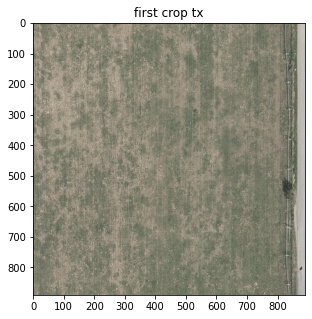

In [29]:
plt.figure(figsize=(5, 5))
plt.imshow(crop1arr)
plt.title("first crop tx")

<Figure size 360x360 with 0 Axes>

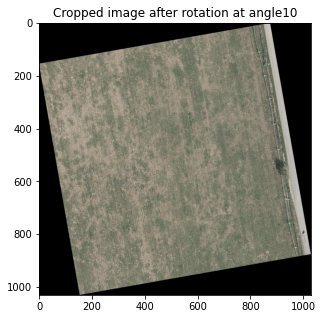

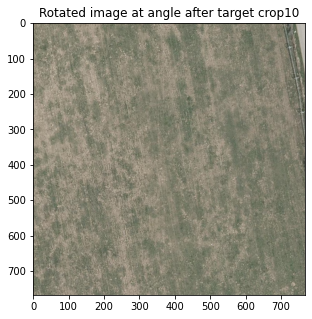

In [30]:
finalcrop = crop_rotate_image(crop1arr, angle, True)

In [31]:
finalcrop.shape

(768, 768, 3)

768 768


Text(0.5, 1.0, 'actual crop on main image')

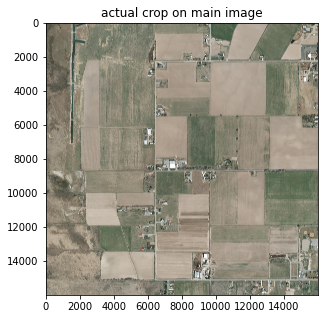

In [32]:
import cv2
import numpy as np

#img = cv2.imread("brows.PNG")              #main image
# gray_img = imarr[:, :, ::-1].copy()
opencvImage1 = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)
gray_img = cv2.cvtColor(opencvImage1,cv2.COLOR_BGR2GRAY)

# template = finalcrop[:, :, ::-1].copy()
opencvImage2 = cv2.cvtColor(finalcrop, cv2.COLOR_RGB2BGR)
template = cv2.cvtColor(opencvImage2,cv2.COLOR_BGR2GRAY)

# print(template.shape, gray_img.shape)
w,h = template.shape[::-1]
print(w,h)

result = cv2.matchTemplate(gray_img, template, cv2.TM_CCOEFF_NORMED)
(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(result)
(startX, startY) = maxLoc
endX = startX + template.shape[1]
endY = startY + template.shape[0]
# draw the bounding box on the image
cv2.rectangle(imarr, (startX, startY), (endX, endY), (255, 0, 0), 1)
# show the output image
plt.figure(figsize=(5, 5))
plt.imshow(imarr)
plt.title("actual crop on main image")

In [33]:
(startX, startY), (endX, endY), endX-startX, endY-startY

((7928, 7287), (8696, 8055), 768, 768)

Text(0.5, 1.0, ' crop target')

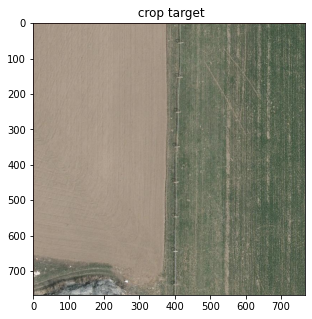

In [35]:
plt.figure(figsize=(5, 5))
plt.imshow(imarr[startY:endY, startX:endX])
plt.title(" crop target")

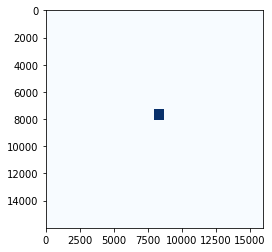

In [36]:
pixel_counter[startY:endY, startX:endX] += 1
generate_heatmap(pixel_counter)